In [2]:
import os
import mne
import pycartool.io
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib qt

import umap
from features import *
from my_io import *

D:\Python\envs\epilespy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
files


['V:\\switchdrive\\Brainhack\\KMR11\\d11\\KMR11_d11_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d13\\KMR11_d13_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d15\\KMR11_d15_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d17\\KMR11_d17_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d19\\KMR11_d19_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d21\\KMR11_d21_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d23\\KMR11_d23_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d25\\KMR11_d25_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d27\\KMR11_d27_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d29\\KMR11_d29_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d3\\KMR11_d3_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d5\\KMR11_d5_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d7\\KMR11_d7_Raw_DS.Avg_ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR11\\d9\\KMR11_d9_Raw_DS.

## Read EEG data

In [3]:
def read_epiliptic_events(file, sfreq):
    df = pd.read_csv(file, sep="\t", skiprows=1, names=['start', 'stop', 'label'])
    df['start_time'] = df['start'] / sfreq
    df['stop_time'] = df['stop'] / sfreq
    df['duration'] = df['stop_time'] - df['start_time']
    df['label'] = [l.split('_')[0] for l in df['label'].values]
    annotations = mne.Annotations(df['start_time'], df['duration'], df['label'])
    return(annotations)
file = fr'V:\switchdrive\Brainhack\KMR11\d17\Epileptic_events.mrk'

def read_file(fname):
    # Read Raw
    base_path = os.path.dirname(fname) 
    base_name = os.path.basename(fname)
    raw = pycartool.io.read_sef(fname)
    # Read Bads
    bad_annotations = mne.Annotations(0, 0, 'null')
    for file in os.listdir(base_path):
        if file.lower().startswith('bad'):
            print(file)
            path = os.path.join(base_path, file)
            annotations = read_bad_file(path, raw.info['sfreq'])
            bad_annotations += annotations
    # Read epileptic
    epileptic_annotations = mne.Annotations(0, 0, 'null')
    for file in os.listdir(base_path):
        if file.lower().startswith('epileptic'):
            print(file)
            path = os.path.join(base_path, file)
            annotations = read_epiliptic_events(path, raw.info['sfreq'])
            epileptic_annotations += annotations
    # Read background
    background_annotations = mne.Annotations(0, 0, 'null')
    for file in os.listdir(base_path):
        if file.lower().endswith('bck.mrk'):
            print(file)
            path = os.path.join(base_path, file)
            annotations = read_background_events_file(path, raw.info['sfreq'])
            background_annotations += annotations
    annotations = epileptic_annotations + bad_annotations + background_annotations
    raw.set_annotations(annotations) 
    return(raw)

In [4]:
files = list()

subject_folder = fr'V:\switchdrive\Brainhack\KMR11'
for day_folder in os.listdir(subject_folder):
    day_folder = os.path.join(subject_folder, day_folder)
    if os.path.isdir(day_folder):
        for file in os.listdir(day_folder):
            if file.endswith('.sef'):
                file = os.path.join(day_folder, file)
                files.append(file)

['background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'backgrou

In [150]:
epochs.events

array([[   28182,        0,        3],
       [   79382,        0,        3],
       [  130582,        0,        3],
       [  386582,        0,        3],
       [  437782,        0,        3],
       [  488982,        0,        3],
       [  540182,        0,        3],
       [  817101,        0,        3],
       [  841054,        0,        3],
       [  858102,        0,        3],
       [  885122,        0,        3],
       [  905044,        0,        3],
       [  921397,        0,        3],
       [  953283,        0,        3],
       [  967878,        0,        3],
       [  984377,        0,        3],
       [ 1032585,        0,        3],
       [ 1053718,        0,        3],
       [ 1094367,        0,        3],
       [ 1123789,        0,        3],
       [ 1204167,        0,        3],
       [ 1259647,        0,        3],
       [ 1292992,        0,        3],
       [ 1329713,        0,        3],
       [ 1353262,        0,        3],
       [ 1434033,        

In [156]:
epochs['HALF'].events

array([], shape=(0, 3), dtype=int32)

In [155]:
np.array([list(events_id.keys())[list(events_id.values()).index(event)] for event in events[:,2]]).reshape(-1,1)

array([['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['background'],
       ['ba

In [169]:
raw.annotations[0]

OrderedDict([('onset', 0.0),
             ('duration', 0.0),
             ('description', 'null'),
             ('orig_time', None)])

In [167]:
events, events_id = mne.events_from_annotations(raw)
np.unique(events[:,2])

Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']


array([1, 2, 3, 4, 5])

In [157]:
raw = read_file(files[1])
events, events_id = mne.events_from_annotations(raw, chunk_duration=chunk_duration)
print(events)
epochs = mne.Epochs(raw, events, event_id=events_id, tmin=0, tmax=1, baseline=None, on_missing='ignore')
events

[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15708224
    Range : 0 ... 15708223 =      0.000 ...  3927.056 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
[[   35576        0        4]
 [   86776        0        4]
 [  137976        0        4]
 [  189176        0        4]
 [  598776        0        4]
 [  649976        0        4]
 [  701176        0        4]
 [  752376        0        4]
 [  803576        0        4]
 [  854776        0        4]
 [  957176        0        4]
 [ 1008376        0        4]
 [ 1161976        0        4]
 [ 1213176        0        4]
 [ 1315576        0        4]
 [ 1417976        0        4]
 [ 1571576        0        4]
 [ 1725176        0        4]
 [ 1878776        0        4]
 [ 1981176        0        4]
 [ 2032376        0        4]
 [ 2083576        0        4]
 [ 2134776  

array([[   35576,        0,        4],
       [   86776,        0,        4],
       [  137976,        0,        4],
       [  189176,        0,        4],
       [  598776,        0,        4],
       [  649976,        0,        4],
       [  701176,        0,        4],
       [  752376,        0,        4],
       [  803576,        0,        4],
       [  854776,        0,        4],
       [  957176,        0,        4],
       [ 1008376,        0,        4],
       [ 1161976,        0,        4],
       [ 1213176,        0,        4],
       [ 1315576,        0,        4],
       [ 1417976,        0,        4],
       [ 1571576,        0,        4],
       [ 1725176,        0,        4],
       [ 1878776,        0,        4],
       [ 1981176,        0,        4],
       [ 2032376,        0,        4],
       [ 2083576,        0,        4],
       [ 2134776,        0,        4],
       [ 2185976,        0,        4],
       [ 2237176,        0,        4],
       [ 2288376,        

In [173]:
bands = [(1,30), (200,240)]
chunk_duration = 1
all_features = []
channel = ['e11']
for file in files:
    try:    
        raw = read_file(file)
        raw.pick(channel)
    except Exception as e:
        print(file , e)
        continue
    day = file.split("\\")[4]
    subject = file.split("\\")[3]
    features = []
    column_names = []
    for band in bands:
        raw.filter(band[0], band[1])
        events, events_id = mne.events_from_annotations(raw)
        epochs = mne.Epochs(raw, events, event_id=events_id, tmin=0, tmax=1, baseline=None,
                            on_missing='ignore', event_repeated='drop')
        data = epochs.get_data()

        activity_features = activity(data)
        features.append(activity_features)
        column_names += [f'{band}_activity_feature_{i}' for i in range(activity_features.shape[-1])]

        mobility_features = mobility(data)
        features.append(mobility_features)
        column_names += [f'{band}_mobility_feature_{i}' for i in range(mobility_features.shape[-1])]

        complexity_features = complexity(data)
        features.append(complexity_features)
        column_names += [f'{band}_complexity_feature_{i}' for i in range(complexity_features.shape[-1])]

        time_features = extract_time_feat(data)
        time_features = time_features.reshape((time_features.shape[0],-1))
        features.append(time_features)
        column_names += [f'{band}_time_feature_{i}' for i in range(time_features.shape[-1])]

        frequency_features = extract_freq_feat(data, sfreq=epochs.info['sfreq'])
        frequency_features = frequency_features.reshape((frequency_features.shape[0],-1))
        features.append(frequency_features)
        column_names += [f'{band}_frequency_feature_{i}' for i in range(frequency_features.shape[-1])]

        information_features = extract_information_feat(data, sfreq=epochs.info['sfreq'])
        information_features = information_features.reshape((information_features.shape[0],-1))
        features.append(information_features)
        column_names += [f'{band}_information_feature_{i}' for i in range(information_features.shape[-1])]

        dwt_features = extract_dwt_feat(data)
        dwt_features = dwt_features.reshape((dwt_features.shape[0],-1))
        features.append(dwt_features)
        column_names += [f'{band}_dwt_feature_{i}' for i in range(dwt_features.shape[-1])]

    events_ = np.array([list(events_id.keys())[list(events_id.values()).index(event)] for event in epochs.events[:,2]]).reshape(-1,1)
    features.append(events_)
    column_names += ['event_name']

    ts = epochs.events[:,0].reshape(-1,1) / raw.info['sfreq']
    features.append(ts)
    column_names += ['start']

    days = np.array([day] * len(epochs)).reshape(-1,1)
    features.append(days)
    column_names += ['day']

    subjects = np.array([subject] * len(epochs)).reshape(-1,1)
    features.append(subjects)
    column_names += ['subject']


    features = np.hstack(features)

    all_features.append(features)
    
df = pd.DataFrame(np.vstack(all_features), columns=column_names)

[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15724608
    Range : 0 ... 15724607 =      0.000 ...  3931.152 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['FR', 'RP', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
305 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


Using data from preloaded Raw for 305 events and 4001 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['FR', 'RP', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
305 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 305 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15708224
    Range : 0 ... 15708223 =      0.000 ...  3927.056 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
174 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 174 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
174 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 174 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15297920
    Range : 0 ... 15297919 =      0.000 ...  3824.480 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['FR', 'RP', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 314 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['FR', 'RP', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 314 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14941504
    Range : 0 ... 14941503 =      0.000 ...  3735.376 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['FR', 'RP', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
324 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 324 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['FR', 'RP', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
324 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 324 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14403904
    Range : 0 ... 14403903 =      0.000 ...  3600.976 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HALF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Using data from preloaded Raw for 153 events and 4001 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HALF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=19329472
    Range : 0 ... 19329471 =      0.000 ...  4832.368 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
226 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
226 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=19748352
    Range : 0 ... 19748351 =      0.000 ...  4937.088 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
222 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


Using data from preloaded Raw for 222 events and 4001 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
222 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 222 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14959040
    Range : 0 ... 14959039 =      0.000 ...  3739.760 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
215 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Using data from preloaded Raw for 215 events and 4001 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
215 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 215 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15884096
    Range : 0 ... 15884095 =      0.000 ...  3971.024 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
191 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Using data from preloaded Raw for 191 events and 4001 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
191 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 191 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=19878144
    Range : 0 ... 19878143 =      0.000 ...  4969.536 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
258 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


Using data from preloaded Raw for 258 events and 4001 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
258 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 258 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14439424
    Range : 0 ... 14439423 =      0.000 ...  3609.856 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['LAHF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
188 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Using data from preloaded Raw for 188 events and 4001 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['LAHF', 'LALF', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
188 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 188 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=12575296
    Range : 0 ... 12575295 =      0.000 ...  3143.824 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
185 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 185 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
185 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 185 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14598144
    Range : 0 ... 14598143 =      0.000 ...  3649.536 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15534976
    Range : 0 ... 15534975 =      0.000 ...  3883.744 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['FR', 'RP', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
344 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 344 events and 4001 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Used Annotations descriptions: ['FR', 'RP', 'background', 'null']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
344 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 344 events and 4001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


In [186]:
df = pd.DataFrame(np.vstack(all_features), columns=column_names)
df['code'] =  pd.Categorical(df.event_name).codes
features = [column for column in df.columns if "feature" in column]
non_features = [column for column in df.columns if not "feature" in column]

df[features].to_csv('features.tsv',sep='\t', index=False, header=False)
df[non_features].to_csv('non_features.tsv',sep='\t')

In [187]:
df

,"(1, 30)_activity_feature_0","(1, 30)_mobility_feature_0","(1, 30)_complexity_feature_0","(1, 30)_time_feature_0","(1, 30)_time_feature_1","(1, 30)_time_feature_2","(1, 30)_time_feature_3","(1, 30)_time_feature_4","(1, 30)_time_feature_5","(1, 30)_time_feature_6",...,"(200, 240)_dwt_feature_15","(200, 240)_dwt_feature_16","(200, 240)_dwt_feature_17","(200, 240)_dwt_feature_18","(200, 240)_dwt_feature_19",event_name,start,day,subject,code
0,886.9391388646229,0.02867625048214165,1.506705664550246,13.912098056646924,886.9391388646229,0.25268651645307594,-0.35547516818439595,0.006489105233136385,0.729354304325119,-0.033738955160238795,...,4.2430377209686445e-05,2.352260599905501e-05,1.5854642040627858,95.61703954427419,0.3753285405493887,null,0.0,d11,KMR11,7
1,62416.62299466576,0.0035253395719044146,8.55093184367444,-49.78580409487607,62416.62299466576,-0.037220649289567434,-1.1884969961434484,-0.013843161641663996,0.7757149825626359,-0.20574669298831424,...,-9.055261592381327e-06,2.023008637849465e-06,-2.685390027063889,76.68522126618221,0.3001030092924338,RP,15.76775,d11,KMR11,5
2,80884.4070403833,0.00406997116998001,8.314770921323515,-86.76088506038602,80884.4070403833,0.33252332032333115,-1.1855167672293323,-0.03051746232442004,1.3398231325920291,-0.13175266943285638,...,-2.0152506522906087e-05,5.715101323717405e-06,-1.9955623014907398,91.16757379610739,0.34433398320599057,RP,61.628,d11,KMR11,5
3,3430.543079444979,0.012293768637105794,3.0686235352267275,8.32418929371439,3430.543079444979,0.1147450709272848,-0.8880298161599796,-0.017241940021643396,0.5184811225090542,-0.04852475395500384,...,-5.981422280366527e-05,6.005769304989609e-05,-0.9202005294604944,98.14436774700016,0.3526993877401239,FR,65.00925,d11,KMR11,0
4,5617.257510227353,0.009469268011946743,3.9317380928516625,37.533352230731325,5617.257510227353,-0.9207842787263365,1.2302944157991114,0.08650565342809229,0.5036828352222332,0.033318727022461844,...,5.8376473381654295e-05,5.051751152520557e-05,1.3136149984866172,97.38808553344059,0.36051671968729015,RP,96.39775,d11,KMR11,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,11606.423158422258,0.009550362432014542,3.792099250196154,3.128592654395506,11606.423158422258,2.7786378852706295,12.24644359246027,-0.12045253722812964,1.0586151545317348,-0.6705395110112743,...,-0.00030324172081884834,0.0009168155240052133,-1.3275365389488687,99.74900056975886,0.44064016679042656,FR,3698.7215,d9,KMR11,0
3249,1501.0633792004166,0.015757913673477494,1.9563885926888382,8.23767565747014,1501.0633792004166,-0.8427046854996634,1.1022353332705261,0.03696719720905103,0.3727318146605791,0.07150849299347,...,0.0001270536417684978,0.00020304708442428336,1.5587220781317819,97.76548720667465,0.4100915280176102,RP,3711.7985,d9,KMR11,5
3250,3932.0790002799063,0.011349856913875954,2.9114410841764156,6.394581601726365,3932.0790002799063,-0.1631340302517523,-1.0262538074586665,-0.03190674050088121,0.5065274754851428,-0.3176764827136264,...,-1.2765715303637806e-05,1.2953364164581574e-06,-0.8181560536780873,51.685925714066734,0.3281094982840804,RP,3788.79125,d9,KMR11,5
3251,2253.7376329186714,0.011688193482552983,3.2301549358864117,-10.900565182848892,2253.7376329186714,0.9693308113565147,2.013949485059893,-0.04364383754034629,0.30789181297860513,-0.20029952734709422,...,-9.931352284845006e-05,9.974686041287286e-05,-1.5273578497664984,98.5100465161551,0.42312914928462586,RP,3807.38825,d9,KMR11,5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


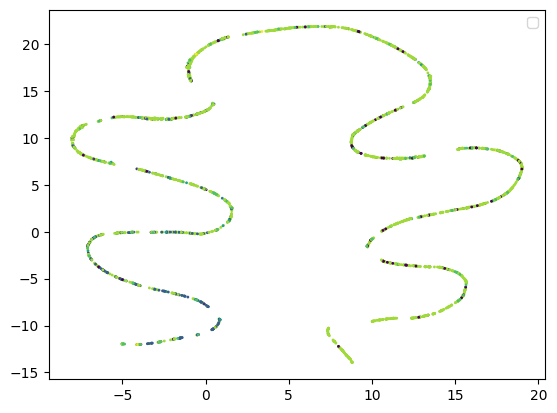

In [178]:
%matplotlib inline
fit = umap.UMAP()
data = df[features].values
u = fit.fit_transform(data)
plt.scatter(u[:,0], u[:,1], c=df['code'] , s=1)
plt.legend()

In [183]:
import umap.plot 
umap.plot.output_notebook()


p = umap.plot.interactive(fit, labels=df['code'],
                          hover_data=df[non_features],
                          point_size=4,
                          theme='fire',
                          background='black',
                          #color_key= ['FR', 'HAHF', 'HALF', 'LAHF', 'LALF', 'RP', 'background', 'null'],
                          interactive_text_search_columns=True)
umap.plot.show(p)

Loading BokehJS ...

In [184]:
day = 25
subject = 11
start = 1516
raw = read_file(fr'V:\\switchdrive\\Brainhack\\KMR{subject}\\d{day}\\KMR{subject}_d{day}_Raw_DS.Avg_ref.sef')

for band in bands:
    raw_ = raw.copy().filter(band[0], band[1])
    raw_.plot(scalings='auto', start=start + chunk_duration, duration=chunk_duration *2)

[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14959040
    Range : 0 ... 14959039 =      0.000 ...  3739.760 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    8.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 60.00 Hz (-6 dB cutoff frequency: 270.00 Hz)
- Filter length: 265 samples (0.066 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   13.1s finished


Channels marked as bad:
none
Channels marked as bad:
none


In [ ]:
umap.plot.interactive?